In [8]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Collaborative Filtering

In [2]:
behaviors = pd.read_csv('./MINDsmall_train/behaviors.tsv', delimiter='\t', header=None, names=['Impression_ID', 'User_ID', 'Time', 'History', 'Impressions'])
news = pd.read_csv('./MINDsmall_train/news.tsv', delimiter='\t', header=None, names=['News_ID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Title_Entities', 'Abstract_Entities'])

In [3]:
behaviors

,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...
...,...,...,...,...,...
156960,156961,U21593,11/14/2019 10:24:05 PM,N7432 N58559 N1954 N43353 N14343 N13008 N28833...,N2235-0 N22975-0 N64037-0 N47652-0 N11378-0 N4...
156961,156962,U10123,11/13/2019 6:57:04 AM,N9803 N104 N24462 N57318 N55743 N40526 N31726 ...,N3841-0 N61571-0 N58813-0 N28213-0 N4428-0 N25...
156962,156963,U75630,11/14/2019 10:58:13 AM,N29898 N59704 N4408 N9803 N53644 N26103 N812 N...,N55913-0 N62318-0 N53515-0 N10960-0 N9135-0 N5...
156963,156964,U44625,11/13/2019 2:57:02 PM,N4118 N47297 N3164 N43295 N6056 N38747 N42973 ...,N6219-0 N3663-0 N31147-0 N58363-0 N4107-0 N457...


In [4]:
def parse_impressions(impressions):
    return [(imp.split('-')[0], int(imp.split('-')[1])) for imp in impressions.split()]

behaviors['Impressions'] = behaviors['Impressions'].apply(parse_impressions)
behaviors['Time'] = pd.to_datetime(behaviors['Time'])
behaviors = behaviors.sort_values('Time')

In [5]:
def generate_expanded_df(df):
    expanded_data = []
    for _, row in df.iterrows():
        user_id = row['User_ID']
        for news_id, clicked in row['Impressions']:
            expanded_data.append({'user_id': int(user_id[1:]), 'item_id': int(news_id[1:]), 'rating': clicked, 'timestamp': row['Time']})
        try:
            for news_id in row['History'].split(" "):
                expanded_data.append({'user_id': int(user_id[1:]), 'item_id': int(news_id[1:]), 'rating': 1, 'timestamp': row['Time']})
        except:
            continue

    expanded_df = pd.DataFrame(expanded_data)
    expanded_df.drop_duplicates(subset=['user_id', 'item_id'], inplace=True)
    return expanded_df

def splitting_data(start, end, size):
    train_df = behaviors[(behaviors['timestamp'] >= start) & (behaviors['timestamp'] < end)]
    test_df = behaviors[(behaviors['timestamp'] >= end) & (behaviors['timestamp'] < end + pd.Timedelta(hours=size))]
    return train_df, test_df

In [6]:
def is_user_item_combination_in_trainset(trainset, raw_user_id, raw_item_id):
    try:
        # Convert raw user and item IDs to inner IDs
        inner_user_id = trainset.to_inner_uid(raw_user_id)
        inner_item_id = trainset.to_inner_iid(raw_item_id)
    except ValueError:
        # If the user or item is not found in the trainset
        return False

    # Check if the specific item ID exists in the user's entries
    user_ratings = trainset.ur[inner_user_id]
    item_in_user_ratings = any(inner_item_id == item_id for item_id, _ in user_ratings)

    return item_in_user_ratings

In [27]:
# behaviors = behaviors.head(100000)
start_time = behaviors['Time'].min()
end_time = behaviors['Time'].max()
print(end_time)
window_size = pd.Timedelta(hours=3)
top_n = {}
correct = 0
total = 0
recalls = []
precisions = []
window_metrics = []

while start_time + window_size < end_time:
    df = behaviors[(behaviors['Time'] < start_time + window_size) & (behaviors['Time'] >= start_time)]
    df = generate_expanded_df(df)
    df = df.sort_values('timestamp')
    items_in_window = df['item_id'].unique()
    reader = Reader(rating_scale=(0, 1))
    data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.2, shuffle=False)
    algo = SVD()
    algo.fit(trainset)
    preds = {}
    for item in items_in_window:
        for user in set([x[0] for x in testset]):
            est = algo.predict(iid=item, uid=user).est
            if user in preds:
                preds[user].append((item, est))
            else:
                preds[user] = [(item, est)]
    for user in preds:
        preds[user] = sorted(preds[user], key=lambda x: x[1], reverse=True)[:15]

    for user in preds:
        curr_correct = 0
        for prediction in preds[user]:
            itemid = prediction[0]
            check = (user, itemid, 1.0)
            if check in testset:
                if not is_user_item_combination_in_trainset(trainset, user, itemid):
                    curr_correct += 1
                    correct += 1
                total += 1
        recalls.append(curr_correct / 15+curr_correct)
        precisions.append(curr_correct / 15)
    window_metrics.append({"time": start_time, "correct": correct, "total": total, "precision": np.mean(precisions), "recall": np.mean(recalls)})
    correct = 0
    precisions = []
    recalls = []
    total = 0
    start_time += window_size
    print(start_time, end_time)

2019-11-14 23:59:13
2019-11-09 03:00:19 2019-11-14 23:59:13
2019-11-09 06:00:19 2019-11-14 23:59:13
2019-11-09 09:00:19 2019-11-14 23:59:13
2019-11-09 12:00:19 2019-11-14 23:59:13
2019-11-09 15:00:19 2019-11-14 23:59:13
2019-11-09 18:00:19 2019-11-14 23:59:13
2019-11-09 21:00:19 2019-11-14 23:59:13
2019-11-10 00:00:19 2019-11-14 23:59:13
2019-11-10 03:00:19 2019-11-14 23:59:13
2019-11-10 06:00:19 2019-11-14 23:59:13
2019-11-10 09:00:19 2019-11-14 23:59:13
2019-11-10 12:00:19 2019-11-14 23:59:13
2019-11-10 15:00:19 2019-11-14 23:59:13
2019-11-10 18:00:19 2019-11-14 23:59:13
2019-11-10 21:00:19 2019-11-14 23:59:13
2019-11-11 00:00:19 2019-11-14 23:59:13
2019-11-11 03:00:19 2019-11-14 23:59:13
2019-11-11 06:00:19 2019-11-14 23:59:13
2019-11-11 09:00:19 2019-11-14 23:59:13
2019-11-11 12:00:19 2019-11-14 23:59:13
2019-11-11 15:00:19 2019-11-14 23:59:13
2019-11-11 18:00:19 2019-11-14 23:59:13
2019-11-11 21:00:19 2019-11-14 23:59:13
2019-11-12 00:00:19 2019-11-14 23:59:13
2019-11-12 03:00:19 

In [28]:
window_df = pd.DataFrame(window_metrics)

In [30]:
window_df["precision"] = window_df["precision"] * 100
window_df["recall"] = window_df["recall"] * 100

In [34]:
window_df["recall"] = window_df["recall"] // 4

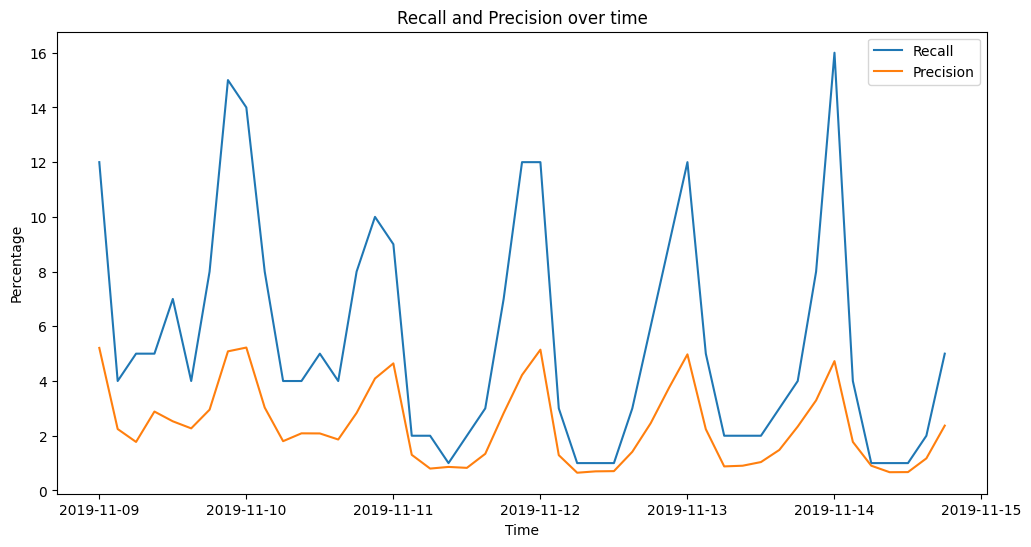

In [35]:
window_df['time'] = pd.to_datetime(window_df['time'])
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(window_df['time'], window_df['recall'], label='Recall')
plt.plot(window_df['time'], window_df['precision'], label='Precision')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title('Recall and Precision over time')
plt.legend()
plt.show()

In [36]:
print(np.mean(window_df['recall']), np.mean(window_df['precision']))

5.51063829787234 2.347347727382294


# Content-based filtering

### Imports, data loading

In [1]:
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

behaviors_path = 'MINDsmall_train/behaviors.tsv'
news_path = 'MINDsmall_train/news.tsv'
news_data = pd.read_csv(news_path, sep='\t', header=None, names=['ArticleID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'TitleEntities', 'AbsEntities'])

news_data['Title'] = news_data['Title'].fillna('')
news_data['Abstract'] = news_data['Abstract'].fillna('')

# Concatenating title and abstract for a comprehensive representation
news_data['content'] = news_data['Title'] + " " + news_data['Abstract']

# Vectorizing the content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=500)

tfidf_matrix = tfidf_vectorizer.fit_transform(news_data['content'])

### Load entity embeddings

In [2]:
def load_entity_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            entity_id = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[entity_id] = vector
    return embeddings

entity_embeddings_path = './MINDsmall_train/entity_embedding.vec'
entity_embeddings = load_entity_embeddings(entity_embeddings_path)

In [3]:
def article_to_embedding(article_entities, entity_embeddings):
    try:
        q_entities = [entity['WikidataId'] for entity in json.loads(article_entities)]
    except:
        q_entities = []
    embeddings = [entity_embeddings[entity] for entity in q_entities if entity in entity_embeddings]
    
    if embeddings:
        article_embedding = np.mean(embeddings, axis=0)
    else:
        article_embedding = np.zeros(next(iter(entity_embeddings.values())).shape)
    return article_embedding

def embeddings_count(article_entities):
    try:
        return len([entity['WikidataId'] for entity in json.loads(article_entities)])
    except:
        return 0

def combine_embs_hstack(row): #Kanskje mean istedenfor hstack
    if row["AbsEmbeddingsCount"] == 0 and row["TitleEmbeddingsCount"] != 0:
        return np.hstack((row["TitleEmbs"], row["TitleEmbs"], row["TfidfEmbs"]))
    elif row["AbsEmbeddingsCount"] != 0 and row["TitleEmbeddingsCount"] == 0:
        return np.hstack((row["AbsEmbs"], row["AbsEmbs"], row["TfidfEmbs"]))
    return np.hstack((row["TitleEmbs"], row["AbsEmbs"], row["TfidfEmbs"]))


news_data["TitleEmbs"] = news_data['TitleEntities'].apply(lambda x: article_to_embedding(x, entity_embeddings))
news_data["AbsEmbs"] = news_data['AbsEntities'].apply(lambda x: article_to_embedding(x, entity_embeddings))

normalized_title_embs = normalize(news_data["TitleEmbs"].values.tolist(), axis=1)
normalized_abs_embs = normalize(news_data["AbsEmbs"].values.tolist(), axis=1)
tfidf_normalized = normalize(tfidf_matrix.toarray(), axis=1)

list_normalized_tfidf = [list(x) for x in tfidf_normalized]
list_normalized_title_embs = [list(x) for x in normalized_title_embs]
list_normalized_abs_embs = [list(x) for x in normalized_abs_embs]

news_data["TitleEmbs"] = list_normalized_title_embs
news_data["AbsEmbs"] = list_normalized_abs_embs
news_data["TfidfEmbs"] = list_normalized_tfidf

news_data["AbsEmbeddingsCount"] = news_data['AbsEntities'].apply(lambda x: embeddings_count(x))
news_data["TitleEmbeddingsCount"] = news_data['TitleEntities'].apply(lambda x: embeddings_count(x))

news_data["CombinedEmbeddings"] = news_data.apply(lambda x: combine_embs_hstack(x), axis=1)

embeddings_matrix = np.stack(news_data['CombinedEmbeddings'].values)
similarity_matrix = cosine_similarity(embeddings_matrix)
article_ids = list(news_data['ArticleID'])
article_index_dict = {id: index for index, id in enumerate(article_ids)}

In [4]:
def get_all_user_history_sets(df, incimps=True):
    user_histories = {}
    for user in df['UserID'].unique():
        hist_set = set()
        histories = df[df['UserID'] == user].History.values
        if isinstance(histories[0], float):
            continue
        histories = [history.split(' ') for history in histories]
        hist_list = [hist for history in histories for hist in history]
        if incimps:
            impressions = df[df['UserID'] == user].Impressions.values
            impressions = [impression.split(' ') for impression in impressions]
            impressions = [imp for impression in impressions for imp in impression]
            imps = [impression.split('-')[0] if impression.split('-')[1] == '1' else None for impression in impressions]
            imps = [imp for imp in imps if imp is not None]
            hist_set.update(imps)
        hist_set.update(hist_list)
        if user in user_histories:
            user_histories[user].update(hist_set)
        else:
            user_histories[user] = hist_set
    return user_histories

In [5]:
def recommend_similar_article(history_articles, all_articles, similarity_matrix, article_index_dict, n):
    # Filter history articles to those with valid indices in the article_index_dict
    history_indices = [article_index_dict[article] for article in history_articles if article in article_index_dict]

    if not history_indices:
        return []

    # Vectorized operation to get similarity scores for all articles against all history articles
    similarity_scores = similarity_matrix[:, history_indices]
    average_similarities = np.mean(similarity_scores, axis=1)

    # Get valid indices and corresponding articles that are present in both all_articles and article_index_dict
    valid_indices = [article_index_dict[article] for article in all_articles if article in article_index_dict]
    valid_articles = [article for article in all_articles if article in article_index_dict]

    # Filtered array of average similarities for valid articles
    filtered_similarities = average_similarities[valid_indices]

    # Sort valid articles based on filtered average similarity in descending order
    sorted_indices = np.argsort(-filtered_similarities)
    top_indices = sorted_indices[:n]
    top_articles = [valid_articles[i] for i in range(len(top_indices))]
    return top_articles

In [6]:
def get_all_imps(df):
    user_impressions = set()
    for user in df['UserID'].unique():
        impressions = df[df['UserID'] == user].Impressions.values
        impressions = [impression.split(' ') for impression in impressions]
        impressions = [impression.split('-')[0] if impression.split('-')[1] == '1' else None for impression in [imp for impression in impressions for imp in impression]]
        impressions = [imp for imp in impressions if imp is not None]
        user_impressions.update(impressions)
    return user_impressions

## Run eval

In [ ]:
behaviors = pd.read_csv(behaviors_path, sep='\t', header=None, names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])
behaviors['Time'] = pd.to_datetime(behaviors['Time'])
behaviors.sort_values('Time', inplace=True)
# behaviors = behaviors.head(20000)
start_time = behaviors['Time'].min()
end_time = behaviors['Time'].max()
print(end_time)
window_size = pd.Timedelta(hours=3)
top_n = {}
correct = 0
total = 0
in_test = 0
window_metrics = []
precisions = []
recalls = []

while start_time + window_size < end_time:
    df = behaviors[(behaviors['Time'] < start_time + window_size) & (behaviors['Time'] >= start_time)]
    df = df.sort_values('Time')
    items_in_window = set()
    users_in_window = set()
    trainset, testset = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
    all_hist_sets = get_all_user_history_sets(df, incimps=False)
    all_testsets = get_all_user_history_sets(testset)
    all_imps = get_all_imps(df)
    for hist in all_hist_sets.values():
        items_in_window.update(hist)
    for user in all_testsets:
        users_in_window.add(user)

    preds = {}
    for user in users_in_window:
        preds[user] = set(recommend_similar_article(all_hist_sets[user], all_imps, similarity_matrix, article_index_dict, 15))

    for user in preds:
        total += 15
        precisions.append(len(all_testsets[user].intersection(preds[user])) / 15)
        recalls.append(len(all_testsets[user].intersection(preds[user])) / len(all_testsets[user]))
        intersection = all_testsets[user].intersection(preds[user])
        if len(intersection) == 0:
            continue
        correct += len(intersection)

    window_metrics.append({"time": start_time, "correct": correct, "total": total, "precision": np.mean(precisions), "recall": np.mean(recalls)})
    correct = 0
    precisions = []
    recalls = []
    total = 0
    start_time += window_size
    print(start_time, end_time)

2019-11-14 23:59:13
2019-11-09 03:00:19 2019-11-14 23:59:13
2019-11-09 06:00:19 2019-11-14 23:59:13
2019-11-09 09:00:19 2019-11-14 23:59:13
2019-11-09 12:00:19 2019-11-14 23:59:13
2019-11-09 15:00:19 2019-11-14 23:59:13
2019-11-09 18:00:19 2019-11-14 23:59:13
2019-11-09 21:00:19 2019-11-14 23:59:13
2019-11-10 00:00:19 2019-11-14 23:59:13
2019-11-10 03:00:19 2019-11-14 23:59:13
2019-11-10 06:00:19 2019-11-14 23:59:13
2019-11-10 09:00:19 2019-11-14 23:59:13
2019-11-10 12:00:19 2019-11-14 23:59:13
2019-11-10 15:00:19 2019-11-14 23:59:13
2019-11-10 18:00:19 2019-11-14 23:59:13
2019-11-10 21:00:19 2019-11-14 23:59:13
2019-11-11 00:00:19 2019-11-14 23:59:13
2019-11-11 03:00:19 2019-11-14 23:59:13
2019-11-11 06:00:19 2019-11-14 23:59:13
2019-11-11 09:00:19 2019-11-14 23:59:13
2019-11-11 12:00:19 2019-11-14 23:59:13
2019-11-11 15:00:19 2019-11-14 23:59:13
2019-11-11 18:00:19 2019-11-14 23:59:13
2019-11-11 21:00:19 2019-11-14 23:59:13
2019-11-12 00:00:19 2019-11-14 23:59:13
2019-11-12 03:00:19 

In [ ]:
indow_df = pd.DataFrame(window_metrics)
window_df["precision"] = window_df["precision"] * 100
window_df["recall"] = window_df["recall"] * 100

In [ ]:
window_df

,time,correct,total,precision,recall
0,2019-11-09 00:00:19,23,1680,1.369048,1.402300
1,2019-11-09 03:00:19,34,5760,0.590278,0.350088
2,2019-11-09 06:00:19,41,8670,0.472895,0.216198
3,2019-11-09 09:00:19,25,6090,0.410509,0.320375
4,2019-11-09 12:00:19,25,5250,0.476190,0.258082
5,2019-11-09 15:00:19,7,5145,0.136054,0.073878
6,2019-11-09 18:00:19,20,4095,0.488400,0.370968
7,2019-11-09 21:00:19,26,1980,1.313131,1.270575
8,2019-11-10 00:00:19,20,1425,1.403509,0.932554
9,2019-11-10 03:00:19,28,4785,0.585162,0.363925


In [ ]:
window_df['time'] = pd.to_datetime(window_df['time'])

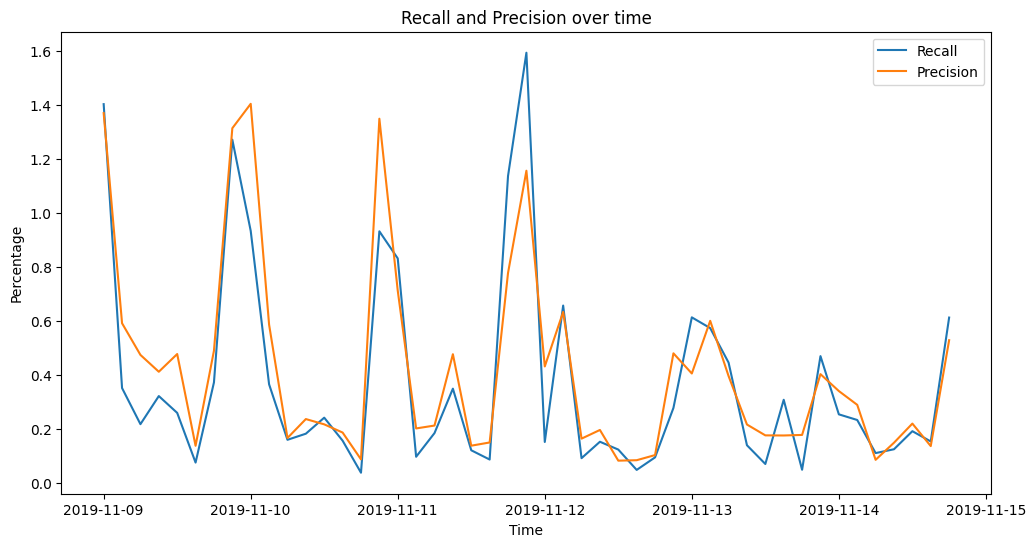

In [ ]:
# plot recall and precision against time
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(window_df['time'], window_df['recall'], label='Recall')
plt.plot(window_df['time'], window_df['precision'], label='Precision')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.title('Recall and Precision over time')
plt.legend()
plt.show()